In [1]:
import sys
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from datasets_transformers import *

from transformers import TrainingArguments, Trainer
from datasets import load_metric

from os import listdir
from os.path import isfile, join

from sklearn.metrics import classification_report, confusion_matrix
from transformers import RobertaTokenizer
from sklearn.preprocessing import LabelEncoder
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from train_transformers import *
        
%load_ext autoreload
%autoreload 2

In [2]:
images_path = "/scratch/students/amvernet/datasets/images"
metadata_path = "/scratch/students/amvernet/datasets/metadata"

metadata = {}
onlyfiles = [f for f in listdir(metadata_path) if isfile(join(metadata_path, f))]
for file in onlyfiles:
    if file.endswith(".json"):
        with (open(join(metadata_path, file), "r")) as f:
            metadata.update(json.loads(f.read()))

In [3]:
def get_results(predictions, LE):
    results = {}
    best_accuracy = 0
    best_model_index = 0
    for i, prediction in enumerate(predictions):
        true = prediction.label_ids
        predicted = prediction.predictions.argmax(-1)

        predicted = torch.nn.functional.softmax(torch.Tensor(prediction.predictions), dim=1).argmax(-1)

        result = classification_report(true, predicted, zero_division=0, output_dict=True, target_names=LE.classes_)
        if result['accuracy'] > best_accuracy:
            best_accuracy = result['accuracy']
            best_model_index = i
        for k, v in result.items():
            if isinstance(v, float):
                if k not in results:
                    results[k] = []
                results[k].append(v)
            if isinstance(v, dict):
                if k not in results:
                    results[k] = {}
                for k2, v2 in v.items():
                    if k2 not in results[k]:
                        results[k][k2] = []
                    results[k][k2].append(v2)

    for k, v in results.items():
        if isinstance(v, list):
            results[k] = np.mean(results[k]), np.std(results[k])
        if isinstance(v, dict):
            for k2, v2 in v.items():
                results[k][k2] = np.mean(results[k][k2]), np.std(results[k][k2])
    
    return results, best_model_index


def print_results(prediction, df, LE, figure_name):
    predicted = prediction.predictions.argmax(-1)
    true = prediction.label_ids
    print(np.mean(predicted == true))
    print(classification_report(true, predicted, zero_division=0, digits=5))

    matrix = confusion_matrix(true, predicted)
    tagset = sorted(df['tag'].unique())
    df_cm = pd.DataFrame(matrix, index= LE.classes_, columns=LE.classes_)
    df_cm = df_cm.rename({'exchange': 'E', 'food prices': 'F', 'miscellaneous': 'M', 
                          'sport results': 'S', 'transport schedule': 'T', 'weather': 'W'})
    df_cm = df_cm.rename({'exchange': 'E', 'food prices': 'F', 'miscellaneous': 'M', 
                          'sport results': 'S', 'transport schedule': 'T', 'weather': 'W'}, axis=1)
    plt.figure(figsize = (6,5))
    g = sn.heatmap(df_cm, annot=True, annot_kws={"size": 15}, fmt='g')
    g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 'x-large')
    g.set_yticklabels(g.get_ymajorticklabels(), fontsize = 'x-large')
    plt.yticks(rotation=0) 
    plt.tight_layout()
    plt.show()

In [4]:
df_B1_train = pd.read_parquet("/scratch/students/amvernet/datasets/text/v2/B1_train.parquet")
df_B1_val = pd.read_parquet("/scratch/students/amvernet/datasets/text/v2/B1_val.parquet")
df_B1_test = pd.read_parquet("/scratch/students/amvernet/datasets/text/v2/B1_test.parquet")

LE = LabelEncoder()
LE.fit(df_B1_train['tag'])

LabelEncoder()

### RoBerta

In [5]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("xlm-roberta-base", per_device_eval_batch_size=4)

test_dataset = BERTDataset(df_B1_test, tokenizer, LE)

In [6]:
predictions_B1_roberta = []
model_paths = ["/scratch/students/amvernet/experiments/2_B1_001/roberta_models/0/best_model_xlm-roberta-base"]

for model_path in model_paths:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)


    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics=compute_metrics)

    prediction = trainer.predict(test_dataset)
    predictions_B1_roberta.append(prediction)

RuntimeError: CUDA error: out of memory

In [9]:
results, best_model_index = get_results(predictions_B1_roberta, LE)
results

{'exchange': {'precision': (0.8640776699029126, 0.0),
  'recall': (0.89, 0.0),
  'f1-score': (0.8768472906403941, 0.0),
  'support': (100.0, 0.0)},
 'food prices': {'precision': (0.9487179487179487, 0.0),
  'recall': (0.9487179487179487, 0.0),
  'f1-score': (0.9487179487179487, 0.0),
  'support': (39.0, 0.0)},
 'miscellaneous': {'precision': (0.9473684210526315, 0.0),
  'recall': (0.7605633802816901, 0.0),
  'f1-score': (0.8437499999999999, 0.0),
  'support': (71.0, 0.0)},
 'sport results': {'precision': (1.0, 0.0),
  'recall': (0.109375, 0.0),
  'f1-score': (0.19718309859154928, 0.0),
  'support': (128.0, 0.0)},
 'transport schedule': {'precision': (0.7901049475262368, 0.0),
  'recall': (0.992467043314501, 0.0),
  'f1-score': (0.8797996661101836, 0.0),
  'support': (531.0, 0.0)},
 'weather': {'precision': (0.0, 0.0),
  'recall': (0.0, 0.0),
  'f1-score': (0.0, 0.0),
  'support': (11.0, 0.0)},
 'accuracy': (0.8193181818181818, 0.0),
 'macro avg': {'precision': (0.7583781645332882, 0.0)

0.8193181818181818
              precision    recall  f1-score   support

           0    0.86408   0.89000   0.87685       100
           1    0.94872   0.94872   0.94872        39
           2    0.94737   0.76056   0.84375        71
           3    1.00000   0.10938   0.19718       128
           4    0.79010   0.99247   0.87980       531
           5    0.00000   0.00000   0.00000        11

    accuracy                        0.81932       880
   macro avg    0.75838   0.61685   0.62438       880
weighted avg    0.83888   0.81932   0.76932       880



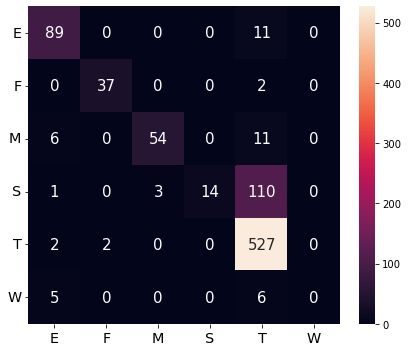

In [10]:
print_results(predictions_B1_roberta[best_model_index], df_B1_test, LE, "roberta_B1")

### LayoutLM

In [11]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("layoutlm-base-uncased", per_device_eval_batch_size=4)

test_dataset = LayoutLMDataset(df_B1_test, metadata, tokenizer, LE)

loading configuration file https://huggingface.co/microsoft/layoutlm-base-uncased/resolve/main/config.json from cache at /home/amvernet/.cache/huggingface/transformers/c59c8df730b08b61677ea9f63ceb3885b726dc72bec3664931831934754e6255.a42e5a49c15f385384232820f72fe4a1f5a14244c183f75fbe7817241fe2ff50
Model config LayoutLMConfig {
  "_name_or_path": "microsoft/layoutlm-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "model_type": "layoutlm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/micro

In [12]:
predictions_B1_layoutlm = []
model_paths = ["/scratch/students/amvernet/experiments/2_B1_001/layoutlm_models/0/best_model_layoutlm-base-uncased/"]

for model_path in model_paths:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics=compute_metrics)

    prediction = trainer.predict(test_dataset)
    predictions_B1_layoutlm.append(prediction)

loading configuration file /scratch/students/amvernet/experiments/2_B1_001/layoutlm_models/0/best_model_layoutlm-base-uncased/config.json
Model config LayoutLMConfig {
  "_name_or_path": "/scratch/students/amvernet/experiments/2_B1_001/layoutlm_models/0/best_model_layoutlm-base-uncased/",
  "architectures": [
    "LayoutLMForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "model_type": "layoutlm",
  "num_attention_heads": 12,
  "num_hidden_lay

In [13]:
results, best_model_index = get_results(predictions_B1_layoutlm, LE)
results

{'exchange': {'precision': (0.9411764705882353, 0.0),
  'recall': (0.96, 0.0),
  'f1-score': (0.9504950495049505, 0.0),
  'support': (100.0, 0.0)},
 'food prices': {'precision': (0.8333333333333334, 0.0),
  'recall': (0.8974358974358975, 0.0),
  'f1-score': (0.8641975308641975, 0.0),
  'support': (39.0, 0.0)},
 'miscellaneous': {'precision': (0.8870967741935484, 0.0),
  'recall': (0.7746478873239436, 0.0),
  'f1-score': (0.8270676691729323, 0.0),
  'support': (71.0, 0.0)},
 'sport results': {'precision': (0.984, 0.0),
  'recall': (0.9609375, 0.0),
  'f1-score': (0.9723320158102766, 0.0),
  'support': (128.0, 0.0)},
 'transport schedule': {'precision': (0.983271375464684, 0.0),
  'recall': (0.9962335216572504, 0.0),
  'f1-score': (0.989710009354537, 0.0),
  'support': (531.0, 0.0)},
 'weather': {'precision': (0.9090909090909091, 0.0),
  'recall': (0.9090909090909091, 0.0),
  'f1-score': (0.9090909090909091, 0.0),
  'support': (11.0, 0.0)},
 'accuracy': (0.9636363636363636, 0.0),
 'macro

0.9636363636363636
              precision    recall  f1-score   support

           0    0.94118   0.96000   0.95050       100
           1    0.83333   0.89744   0.86420        39
           2    0.88710   0.77465   0.82707        71
           3    0.98400   0.96094   0.97233       128
           4    0.98327   0.99623   0.98971       531
           5    0.90909   0.90909   0.90909        11

    accuracy                        0.96364       880
   macro avg    0.92299   0.91639   0.91882       880
weighted avg    0.96326   0.96364   0.96303       880



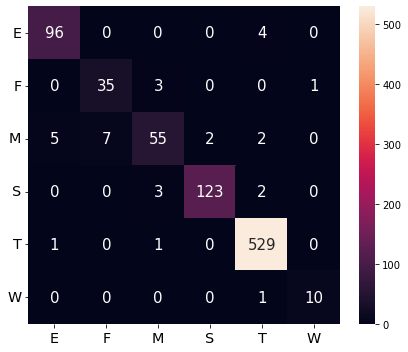

In [14]:
print_results(predictions_B1_layoutlm[best_model_index], df_B1_test, LE, "layoutlm_B1")

### LayoutXLM

In [15]:
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
tokenizer = LayoutXLMTokenizer.from_pretrained('microsoft/layoutxlm-base')
processor = LayoutXLMProcessor(feature_extractor, tokenizer)

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("layoutxlm-base", per_device_eval_batch_size=4)

test_dataset = LayoutXLMDataset(df_B1_test, metadata, processor, LE, images_path)

loading file https://huggingface.co/microsoft/layoutxlm-base/resolve/main/sentencepiece.bpe.model from cache at /home/amvernet/.cache/huggingface/transformers/db844fb5c32918721ed233d2411496a5dad53b43140ce01851ee7ee5d1403528.71e50b08dbe7e5375398e165096cacc3d2086119d6a449364490da6908de655e
loading file https://huggingface.co/microsoft/layoutxlm-base/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/microsoft/layoutxlm-base/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/microsoft/layoutxlm-base/resolve/main/tokenizer_config.json from cache at None
loading file https://huggingface.co/microsoft/layoutxlm-base/resolve/main/tokenizer.json from cache at /home/amvernet/.cache/huggingface/transformers/c9202fe65b5d10a23dc6251d2a9b14829f1381416c511d376cf456ed8b5b5c01.a984cf52fc87644bd4a2165f1e07e0ac880272c1e82d648b4674907056912bd7
loading configuration file https://huggingface.co/microsoft/layoutxlm-base/resolve/main/

In [16]:
predictions_B1_layoutxlm = []
model_paths = ["/scratch/students/amvernet/experiments/2_B1_001/layoutxlm_models/0/best_model_layoutxlm-base/"]

for model_path in model_paths:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics=compute_metrics)
    
    prediction = trainer.predict(test_dataset)
    predictions_B1_layoutxlm.append(prediction)

loading configuration file /scratch/students/amvernet/experiments/2_B1_001/layoutxlm_models/0/best_model_layoutxlm-base/config.json
Model config LayoutLMv2Config {
  "_name_or_path": "/scratch/students/amvernet/experiments/2_B1_001/layoutxlm_models/0/best_model_layoutxlm-base/",
  "architectures": [
    "LayoutLMv2ForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "convert_sync_batchnorm": true,
  "coordinate_size": 128,
  "detectron2_config_args": {
    "MODEL.ANCHOR_GENERATOR.SIZES": [
      [
        32
      ],
      [
        64
      ],
      [
        128
      ],
      [
        256
      ],
      [
        512
      ]
    ],
    "MODEL.BACKBONE.NAME": "build_resnet_fpn_backbone",
    "MODEL.FPN.IN_FEATURES": [
      "res2",
      "res3",
      "res4",
      "res5"
    ],
    "MODEL.MASK_ON": true,
    "MODEL.PIXEL_STD": [
      57.375,
      57.12,
      58.395
    ],
    "MODEL.POST_NMS_TOPK_TEST": 1000,
    "MODEL.RESNETS.ASPECT_RAT

In [17]:
results, best_model_index = get_results(predictions_B1_layoutxlm, LE)
results

{'exchange': {'precision': (0.9891304347826086, 0.0),
  'recall': (0.91, 0.0),
  'f1-score': (0.9479166666666667, 0.0),
  'support': (100.0, 0.0)},
 'food prices': {'precision': (0.9, 0.0),
  'recall': (0.9230769230769231, 0.0),
  'f1-score': (0.9113924050632911, 0.0),
  'support': (39.0, 0.0)},
 'miscellaneous': {'precision': (0.863013698630137, 0.0),
  'recall': (0.8873239436619719, 0.0),
  'f1-score': (0.875, 0.0),
  'support': (71.0, 0.0)},
 'sport results': {'precision': (0.9841269841269841, 0.0),
  'recall': (0.96875, 0.0),
  'f1-score': (0.9763779527559054, 0.0),
  'support': (128.0, 0.0)},
 'transport schedule': {'precision': (0.9851301115241635, 0.0),
  'recall': (0.9981167608286252, 0.0),
  'f1-score': (0.9915809167446211, 0.0),
  'support': (531.0, 0.0)},
 'weather': {'precision': (1.0, 0.0),
  'recall': (1.0, 0.0),
  'f1-score': (1.0, 0.0),
  'support': (11.0, 0.0)},
 'accuracy': (0.9715909090909091, 0.0),
 'macro avg': {'precision': (0.9535668715106489, 0.0),
  'recall': (

0.9715909090909091
              precision    recall  f1-score   support

           0    0.98913   0.91000   0.94792       100
           1    0.90000   0.92308   0.91139        39
           2    0.86301   0.88732   0.87500        71
           3    0.98413   0.96875   0.97638       128
           4    0.98513   0.99812   0.99158       531
           5    1.00000   1.00000   1.00000        11

    accuracy                        0.97159       880
   macro avg    0.95357   0.94788   0.95038       880
weighted avg    0.97200   0.97159   0.97155       880



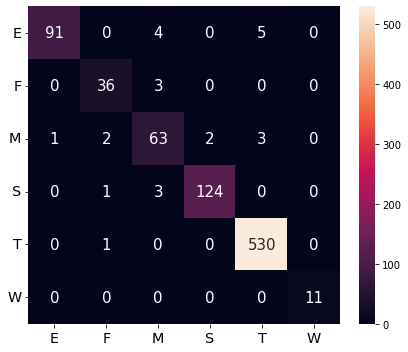

In [18]:
print_results(predictions_B1_layoutxlm[best_model_index], df_B1_test, LE, "layoutxlm_B1")

# Dataset C

In [4]:
df_C_train = pd.read_parquet("/scratch/students/amvernet/datasets/fixed_annotations/NLL_auto_train.parquet")
df_C_val = pd.read_parquet("/scratch/students/amvernet/datasets/fixed_annotations/NLL_auto_val.parquet")
df_C_test = pd.read_parquet("/scratch/students/amvernet/datasets/fixed_annotations/NLL_auto_test.parquet")


LE = LabelEncoder()
LE.fit(df_C_train['tag'])

LabelEncoder()

### RoBerta

In [6]:
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("xlm-roberta-base", per_device_eval_batch_size=4)

test_dataset = BERTDataset(df_C_test, tokenizer, LE)

In [13]:
predictions_C_roberta = []
model_paths = ["/scratch/students/amvernet/experiments/TC_NLL_auto/roberta/0/best_model_xlm-roberta-base"]

for model_path in model_paths:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics=compute_metrics)
    
    prediction = trainer.predict(test_dataset)
    predictions_C_roberta.append(prediction)

loading configuration file /scratch/students/amvernet/experiments/TC_NLL_auto/roberta/0/best_model_xlm-roberta-base/config.json
Model config XLMRobertaConfig {
  "_name_or_path": "/scratch/students/amvernet/experiments/TC_NLL_auto/roberta/0/best_model_xlm-roberta-base",
  "architectures": [
    "XLMRobertaForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "xlm-roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,


In [14]:
results, best_model_index = get_results(predictions_C_roberta, LE)
results

{'exchange': {'precision': (0.9683257918552036, 0.0),
  'recall': (0.9511111111111111, 0.0),
  'f1-score': (0.9596412556053812, 0.0),
  'support': (225.0, 0.0)},
 'food prices': {'precision': (0.9824561403508771, 0.0),
  'recall': (0.9032258064516129, 0.0),
  'f1-score': (0.9411764705882352, 0.0),
  'support': (124.0, 0.0)},
 'miscellaneous': {'precision': (0.8404255319148937, 0.0),
  'recall': (0.8494623655913979, 0.0),
  'f1-score': (0.8449197860962566, 0.0),
  'support': (93.0, 0.0)},
 'sport results': {'precision': (0.9247311827956989, 0.0),
  'recall': (1.0, 0.0),
  'f1-score': (0.9608938547486032, 0.0),
  'support': (86.0, 0.0)},
 'transport schedule': {'precision': (0.9889737065309584, 0.0),
  'recall': (0.9931856899488927, 0.0),
  'f1-score': (0.9910752231194221, 0.0),
  'support': (1174.0, 0.0)},
 'weather': {'precision': (0.875, 0.0),
  'recall': (1.0, 0.0),
  'f1-score': (0.9333333333333333, 0.0),
  'support': (7.0, 0.0)},
 'accuracy': (0.9736688121708601, 0.0),
 'macro avg'

0.9736688121708601
              precision    recall  f1-score   support

           0    0.96833   0.95111   0.95964       225
           1    0.98246   0.90323   0.94118       124
           2    0.84043   0.84946   0.84492        93
           3    0.92473   1.00000   0.96089        86
           4    0.98897   0.99319   0.99108      1174
           5    0.87500   1.00000   0.93333         7

    accuracy                        0.97367      1709
   macro avg    0.92999   0.94950   0.93851      1709
weighted avg    0.97400   0.97367   0.97361      1709



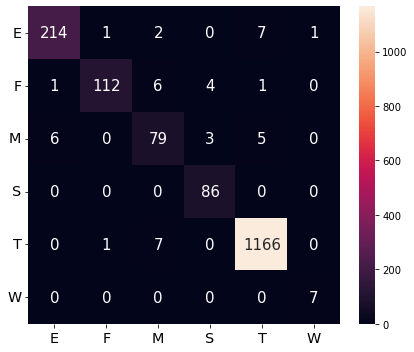

In [18]:
print_results(predictions_C_roberta[best_model_index], df_C_test, LE, "roberta_C")

### LayoutLM

In [19]:
tokenizer = AutoTokenizer.from_pretrained("microsoft/layoutlm-base-uncased")

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("layoutlm-base-uncased", per_device_eval_batch_size=4)

test_dataset = LayoutLMDataset(df_C_test, metadata, tokenizer, LE)

loading configuration file https://huggingface.co/microsoft/layoutlm-base-uncased/resolve/main/config.json from cache at /home/amvernet/.cache/huggingface/transformers/c59c8df730b08b61677ea9f63ceb3885b726dc72bec3664931831934754e6255.a42e5a49c15f385384232820f72fe4a1f5a14244c183f75fbe7817241fe2ff50
Model config LayoutLMConfig {
  "_name_or_path": "microsoft/layoutlm-base-uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "model_type": "layoutlm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.14.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/micro

In [20]:
predictions_C_layoutlm = []
model_paths = ["/scratch/students/amvernet/experiments/TC_NLL_auto/layoutlm/0/best_model_layoutlm-base-uncased/"]

for model_path in model_paths:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics=compute_metrics)

    prediction = trainer.predict(test_dataset)
    predictions_C_layoutlm.append(prediction)

loading configuration file /scratch/students/amvernet/experiments/TC_NLL_auto/layoutlm/0/best_model_layoutlm-base-uncased/config.json
Model config LayoutLMConfig {
  "_name_or_path": "/scratch/students/amvernet/experiments/TC_NLL_auto/layoutlm/0/best_model_layoutlm-base-uncased/",
  "architectures": [
    "LayoutLMForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5
  },
  "layer_norm_eps": 1e-12,
  "max_2d_position_embeddings": 1024,
  "max_position_embeddings": 512,
  "model_type": "layoutlm",
  "num_attention_heads": 12,
  "num_hidden_layers": 12

In [21]:
results, best_model_index = get_results(predictions_C_layoutlm, LE)
results

{'exchange': {'precision': (0.9726027397260274, 0.0),
  'recall': (0.9466666666666667, 0.0),
  'f1-score': (0.9594594594594594, 0.0),
  'support': (225.0, 0.0)},
 'food prices': {'precision': (0.9745762711864406, 0.0),
  'recall': (0.9274193548387096, 0.0),
  'f1-score': (0.9504132231404958, 0.0),
  'support': (124.0, 0.0)},
 'miscellaneous': {'precision': (0.8829787234042553, 0.0),
  'recall': (0.8924731182795699, 0.0),
  'f1-score': (0.8877005347593583, 0.0),
  'support': (93.0, 0.0)},
 'sport results': {'precision': (0.9767441860465116, 0.0),
  'recall': (0.9767441860465116, 0.0),
  'f1-score': (0.9767441860465116, 0.0),
  'support': (86.0, 0.0)},
 'transport schedule': {'precision': (0.9881856540084388, 0.0),
  'recall': (0.9974446337308348, 0.0),
  'f1-score': (0.9927935565917761, 0.0),
  'support': (1174.0, 0.0)},
 'weather': {'precision': (1.0, 0.0),
  'recall': (1.0, 0.0),
  'f1-score': (1.0, 0.0),
  'support': (7.0, 0.0)},
 'accuracy': (0.9789350497366881, 0.0),
 'macro avg': 

0.9789350497366881
              precision    recall  f1-score   support

           0    0.97260   0.94667   0.95946       225
           1    0.97458   0.92742   0.95041       124
           2    0.88298   0.89247   0.88770        93
           3    0.97674   0.97674   0.97674        86
           4    0.98819   0.99744   0.99279      1174
           5    1.00000   1.00000   1.00000         7

    accuracy                        0.97894      1709
   macro avg    0.96585   0.95679   0.96119      1709
weighted avg    0.97889   0.97894   0.97883      1709



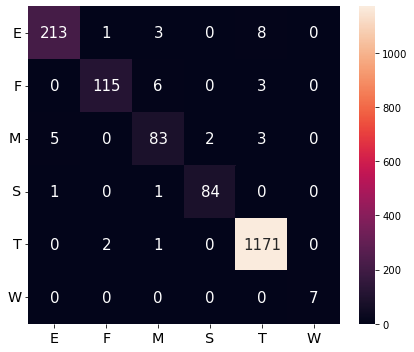

In [22]:
print_results(predictions_C_layoutlm[best_model_index], df_C_test, LE, "layoutlm_C")

### LayoutXLM

In [5]:
feature_extractor = LayoutLMv2FeatureExtractor(apply_ocr=False)
tokenizer = LayoutXLMTokenizer.from_pretrained('microsoft/layoutxlm-base')
processor = LayoutXLMProcessor(feature_extractor, tokenizer)

def compute_metrics(eval_pred):
    metric = load_metric("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

training_args = TrainingArguments("layoutxlm-base", per_device_eval_batch_size=4)

test_dataset = LayoutXLMDataset(df_C_test, metadata, processor, LE, images_path)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'LayoutLMv2Tokenizer'. 
The class this function is called from is 'LayoutXLMTokenizer'.


In [6]:
predictions_C_layoutxlm = []
model_paths = ["/scratch/students/amvernet/experiments/TC_NLL_auto/layoutxlm/0/best_model_layoutxlm-base"]

for model_path in model_paths:
    model = AutoModelForSequenceClassification.from_pretrained(model_path)

    trainer = Trainer(model=model,
                      args=training_args,
                      compute_metrics=compute_metrics)
    prediction = trainer.predict(test_dataset)
    predictions_C_layoutxlm.append(prediction)

***** Running Prediction *****
  Num examples = 1709
  Batch size = 4


In [7]:
results, best_model_index = get_results(predictions_C_layoutxlm, LE)
results

{'exchange': {'precision': (0.9734513274336283, 0.0),
  'recall': (0.9777777777777777, 0.0),
  'f1-score': (0.975609756097561, 0.0),
  'support': (225.0, 0.0)},
 'food prices': {'precision': (0.9819819819819819, 0.0),
  'recall': (0.8790322580645161, 0.0),
  'f1-score': (0.927659574468085, 0.0),
  'support': (124.0, 0.0)},
 'miscellaneous': {'precision': (0.8269230769230769, 0.0),
  'recall': (0.9247311827956989, 0.0),
  'f1-score': (0.8730964467005077, 0.0),
  'support': (93.0, 0.0)},
 'sport results': {'precision': (0.9770114942528736, 0.0),
  'recall': (0.9883720930232558, 0.0),
  'f1-score': (0.9826589595375722, 0.0),
  'support': (86.0, 0.0)},
 'transport schedule': {'precision': (0.9957374254049446, 0.0),
  'recall': (0.9948892674616695, 0.0),
  'f1-score': (0.9953131657435024, 0.0),
  'support': (1174.0, 0.0)},
 'weather': {'precision': (0.875, 0.0),
  'recall': (1.0, 0.0),
  'f1-score': (0.9333333333333333, 0.0),
  'support': (7.0, 0.0)},
 'accuracy': (0.9801053247513165, 0.0),

0.9801053247513165
              precision    recall  f1-score   support

           0    0.97345   0.97778   0.97561       225
           1    0.98198   0.87903   0.92766       124
           2    0.82692   0.92473   0.87310        93
           3    0.97701   0.98837   0.98266        86
           4    0.99574   0.99489   0.99531      1174
           5    0.87500   1.00000   0.93333         7

    accuracy                        0.98011      1709
   macro avg    0.93835   0.96080   0.94795      1709
weighted avg    0.98118   0.98011   0.98027      1709



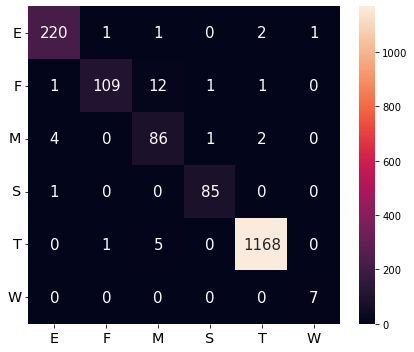

In [8]:
print_results(predictions_C_layoutxlm[best_model_index], df_C_test, LE, "layoutxlm_C")